# Imports and reading data

In [1]:
import os
import pandas as pd
from ydata_profiling import ProfileReport

DATA_FOLDER = "data"
CRM_PATH = os.path.join(DATA_FOLDER, "crm_data.csv")
WEB_TRACKING_PATH = os.path.join(DATA_FOLDER, "web_tracking.csv")

In [2]:
crm_df = pd.read_csv(CRM_PATH)
web_tracking_df = pd.read_csv(WEB_TRACKING_PATH)

# EDA + Data validation

In [3]:
crm_df#.columns

,user_id,lead_status,company,sign_up_date,industry,country
0,137,Converted,Company_0,2024-03-09,Healthcare,US
1,163,Converted,Company_1,2024-03-01,Finance,UK
2,103,Prospect,Company_2,2024-03-02,Healthcare,France
3,163,Lost,Company_3,2024-03-01,SaaS,US
4,171,Lost,Company_4,2024-03-07,Healthcare,Germany
5,151,Converted,Company_5,2024-03-01,Finance,US
6,141,Prospect,Company_6,2024-03-02,E-commerce,Germany
7,117,Lost,Company_7,2024-03-08,Finance,France
8,114,Lost,Company_8,2024-03-09,Finance,UK
9,171,Prospect,Company_9,2024-03-10,Finance,US


In [4]:
crm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       60 non-null     int64 
 1   lead_status   60 non-null     object
 2   company       60 non-null     object
 3   sign_up_date  60 non-null     object
 4   industry      60 non-null     object
 5   country       60 non-null     object
dtypes: int64(1), object(5)
memory usage: 2.9+ KB


In [5]:
crm_df.isna().sum()

user_id         0
lead_status     0
company         0
sign_up_date    0
industry        0
country         0
dtype: int64

In [6]:
crm_df.nunique()

user_id         47
lead_status      3
company         60
sign_up_date    11
industry         4
country          4
dtype: int64

**Warning:** user_id is not unique

In [7]:
crm_df["sign_up_date"] = pd.to_datetime(crm_df["sign_up_date"] )

In [8]:
crm_df["sign_up_date"].describe()

count                     60
mean     2024-03-05 16:24:00
min      2024-03-01 00:00:00
25%      2024-03-02 00:00:00
50%      2024-03-06 00:00:00
75%      2024-03-09 00:00:00
max      2024-03-11 00:00:00
Name: sign_up_date, dtype: object

In [9]:
crm_df[crm_df.user_id.duplicated()] 

,user_id,lead_status,company,sign_up_date,industry,country
3,163,Lost,Company_3,2024-03-01,SaaS,US
9,171,Prospect,Company_9,2024-03-10,Finance,US
20,161,Converted,Company_20,2024-03-11,Finance,US
31,187,Converted,Company_31,2024-03-04,E-commerce,US
33,150,Prospect,Company_33,2024-03-10,SaaS,UK
35,120,Prospect,Company_35,2024-03-06,SaaS,Germany
36,103,Prospect,Company_36,2024-03-07,SaaS,UK
39,161,Converted,Company_39,2024-03-01,Finance,US
40,146,Lost,Company_40,2024-03-03,Finance,US
52,102,Converted,Company_52,2024-03-02,SaaS,US


In [10]:
def plot_column_distribution(df, col_name):
    result = df[col_name].value_counts()
    print(result)
    return result.plot(kind = "bar")

lead_status
Converted    25
Lost         18
Prospect     17
Name: count, dtype: int64


<Axes: xlabel='lead_status'>

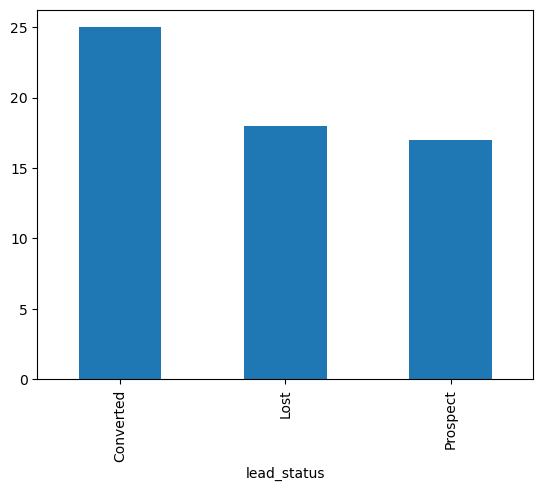

In [11]:
plot_column_distribution(crm_df, "lead_status")

In [12]:
(crm_df["lead_status"] == "Converted").sum() / len(crm_df)

0.4166666666666667

industry
Finance       22
SaaS          15
E-commerce    14
Healthcare     9
Name: count, dtype: int64


<Axes: xlabel='industry'>

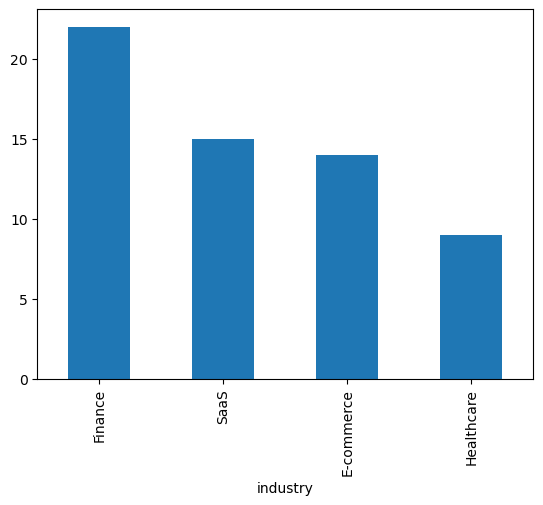

In [13]:
plot_column_distribution(crm_df, "industry")

country
US         27
UK         14
Germany    12
France      7
Name: count, dtype: int64


<Axes: xlabel='country'>

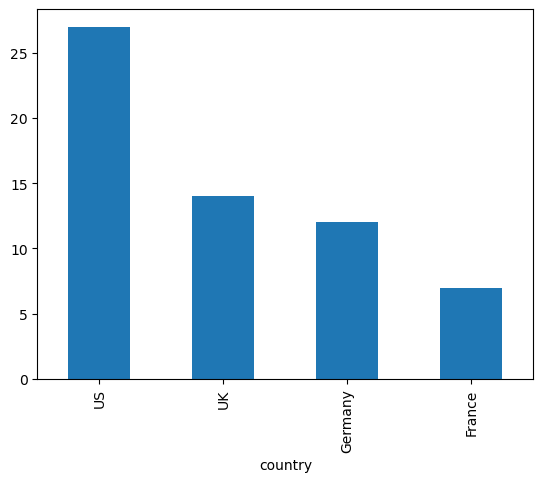

In [14]:
plot_column_distribution(crm_df, "country")

- There are three options for lead_status: ("converted", "lost", "prospect")
- lead_status = "converted" is the most likely to appear with 25 incides (42%)
- The largest groups of web activity:
    - Industry: Finance (22)
    - Country: US (27)
- The smallest groups of web activity:
    - Industry: Healthcare (9)
    - Country: France (7) 

In [59]:
def get_conversion_rate(values, prospects = True):
    # print(values)
    num_converted = values[values == "Converted"].shape[0]
    if prospects:
        total = values.shape[0]
    else:
        total = values[values != "Prospect"].shape[0]
    percentage = num_converted / total * 100
    return percentage
    # converted = values[values["lead_status"] == "Converted"].shape[0]

In [60]:
def plot_conversion_rate_by_column(df, col_name, prospects = True):
    conv_rate = df.groupby(col_name)["lead_status"].apply(lambda x: get_conversion_rate(x, prospects))
    sorted_conv_rates = conv_rate.sort_values(ascending = False)
    print(sorted_conv_rates)
    return sorted_conv_rates.plot(kind = "bar")

country
US         59.259259
UK         42.857143
Germany    16.666667
France     14.285714
Name: lead_status, dtype: float64


<Axes: xlabel='country'>

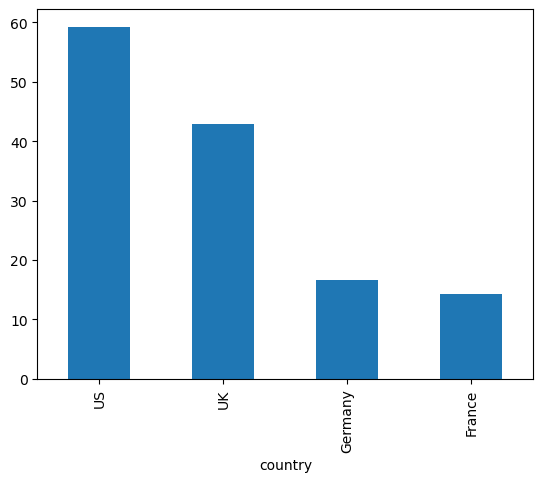

In [61]:
plot_conversion_rate_by_column(crm_df, "country")

industry
Healthcare    55.555556
Finance       40.909091
SaaS          40.000000
E-commerce    35.714286
Name: lead_status, dtype: float64


<Axes: xlabel='industry'>

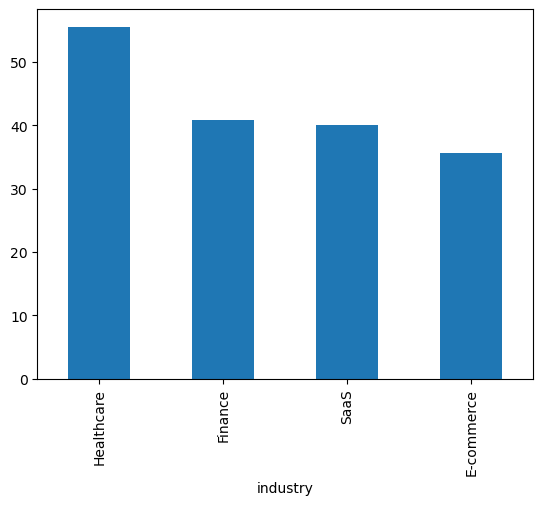

In [62]:
plot_conversion_rate_by_column(crm_df, "industry")

- The US has highest conversion rate (59%) in contrast to France with the lowest (14%)
- Healthcare has highest conversion rate (55%) in contrast to E-commerce (36%)
- **NOTE:** This conversion rate calculation also includes lead_status = "prospects"

industry
Healthcare    71.428571
SaaS          66.666667
Finance       52.941176
E-commerce    50.000000
Name: lead_status, dtype: float64


<Axes: xlabel='industry'>

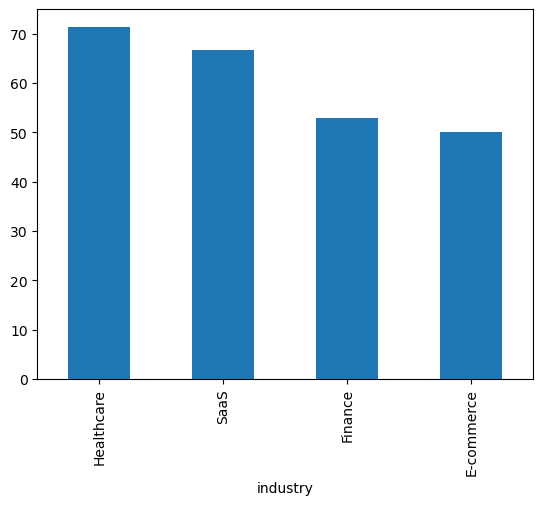

In [63]:
plot_conversion_rate_by_column(crm_df, "industry", prospects = False)

country
US         69.565217
UK         66.666667
France     33.333333
Germany    25.000000
Name: lead_status, dtype: float64


<Axes: xlabel='country'>

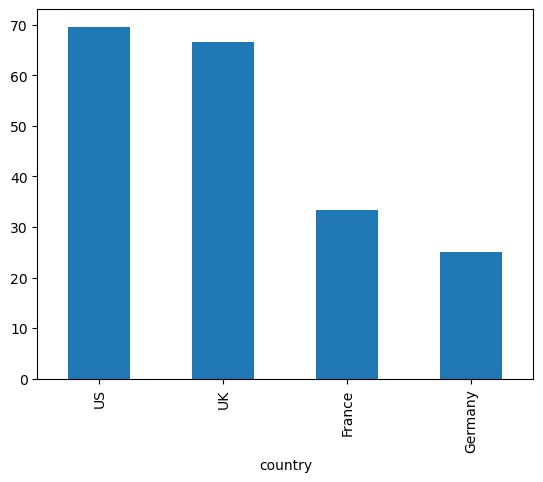

In [64]:
plot_conversion_rate_by_column(crm_df, "country", prospects = False)

- findings change drastically by not including lead_status = "Prospect"
    - Industry: Conversion rate differences are less between industries (ranges from 51% (E-commerce) to 71% (Healthcare)
    - Country: The lowest country now is Germany with 25% and US with increased conversionrate of 69%

# Web Tracking Data

In [65]:
web_tracking_df.columns

Index(['user_id', 'session_id', 'timestamp', 'page', 'time_spent_sec',
       'utm_source', 'utm_medium', 'device_type'],
      dtype='object')

In [66]:
web_tracking_df.head()

,user_id,session_id,timestamp,page,time_spent_sec,utm_source,utm_medium,device_type
34,159,s034,2024-03-01 01:18:00,/features,90,google,organic,mobile
36,114,s036,2024-03-01 01:28:00,/contact,122,newsletter,cpc,mobile
90,171,s090,2024-03-01 01:45:00,/contact,217,google,referral,desktop
97,181,s097,2024-03-01 03:04:00,/contact,84,google,organic,mobile
82,133,s082,2024-03-01 04:29:00,/pricing,263,newsletter,cpc,mobile


In [67]:
web_tracking_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 34 to 39
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         100 non-null    int64         
 1   session_id      100 non-null    object        
 2   timestamp       100 non-null    datetime64[ns]
 3   page            100 non-null    object        
 4   time_spent_sec  100 non-null    int64         
 5   utm_source      100 non-null    object        
 6   utm_medium      100 non-null    object        
 7   device_type     100 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 7.0+ KB


In [68]:
web_tracking_df["timestamp"] = pd.to_datetime(web_tracking_df["timestamp"])

In [69]:
web_tracking_df.time_spent_sec.describe()

count    100.000000
mean     163.750000
std       71.941106
min       11.000000
25%      121.750000
50%      156.500000
75%      227.500000
max      295.000000
Name: time_spent_sec, dtype: float64

In [26]:
web_tracking_df.timestamp.describe()

count                              100
mean     2024-03-04 12:31:25.199999744
min                2024-03-01 01:18:00
25%                2024-03-02 18:32:15
50%                2024-03-04 16:09:30
75%                2024-03-06 04:45:15
max                2024-03-07 21:13:00
Name: timestamp, dtype: object

**NOTE:** Web tracking until 03-07, but users signed up until 03-10

<Axes: ylabel='Frequency'>

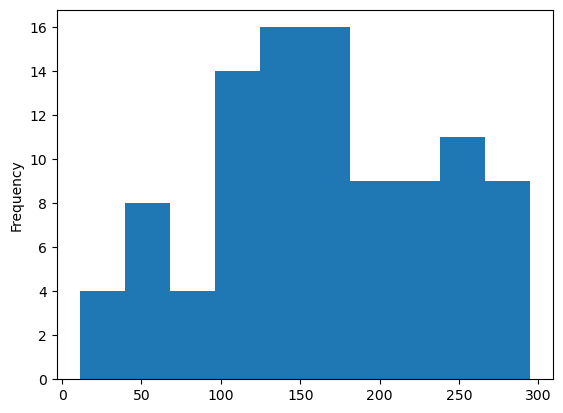

In [27]:
web_tracking_df.time_spent_sec.plot(kind= "hist")

In [28]:
web_tracking_df.nunique()

user_id            61
session_id        100
timestamp          99
page                4
time_spent_sec     74
utm_source          4
utm_medium          4
device_type         3
dtype: int64

**Warning:** Some users are missing in the crm

In [29]:
set(web_tracking_df["user_id"]) - set(crm_df["user_id"])

{101, 105, 113, 129, 133, 135, 139, 148, 153, 172, 175, 179, 182, 186}

**NOTE:** user_id {101, 105, 113, 129, 133, 135, 139, 148, 153, 172, 175, 179, 182, 186} have web tracking data but are missing for crm

In [30]:
web_tracking_df.isna().sum()

user_id           0
session_id        0
timestamp         0
page              0
time_spent_sec    0
utm_source        0
utm_medium        0
device_type       0
dtype: int64

In [31]:
web_tracking_df.sort_values("timestamp", inplace = True)

In [104]:
nb_of_pages_visited = web_tracking_df.user_id.value_counts()
nb_of_pages_visited_df = nb_of_pages_visited.to_frame().reset_index()
nb_of_pages_visited_df.rename(columns = {"count":"numb_pages"}, inplace = True)

In [110]:
nb_of_pages_visited

user_id
161    5
159    4
101    4
120    3
114    3
      ..
149    1
154    1
138    1
105    1
173    1
Name: count, Length: 61, dtype: int64

In [33]:
def get_last_page(x):
    last_page = x.to_list()[-1]
    return last_page

In [34]:
last_page = web_tracking_df.groupby('user_id').page.apply(get_last_page)

In [54]:
last_page_df = last_page.to_frame().reset_index()
last_page_df.rename(columns = {"page":"last_page"}, inplace=True)

In [85]:
def get_first_page(x):
    first_page = x.to_list()[0]
    return first_page

In [89]:
first_page = web_tracking_df.groupby('user_id').page.apply(get_first_page)

In [90]:
first_page_df = first_page.to_frame().reset_index()
first_page_df.rename(columns = {"page":"first_page"}, inplace=True)

In [105]:
merged_df = crm_df.merge(web_tracking_df, on = "user_id") \
            .merge(last_page_df, on = "user_id")\
            .merge(first_page_df, on = "user_id")\
            .merge(nb_of_pages_visited_df, on = "user_id")

last_page
/pricing     54.545455
/landing     46.428571
/features    46.000000
/contact     25.000000
Name: lead_status, dtype: float64


<Axes: xlabel='last_page'>

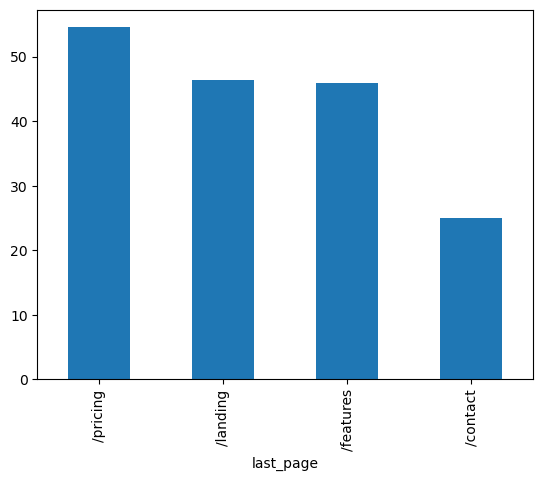

In [106]:
plot_conversion_rate_by_column(merged_df, "last_page")

- if a user ends on contact page he/she does not converse in 3 out of 4 cases
- if a user ends on pricing page he/she converse in 54% of the cases

first_page
/landing     60.000000
/pricing     58.333333
/features    46.428571
/contact     29.824561
Name: lead_status, dtype: float64


<Axes: xlabel='first_page'>

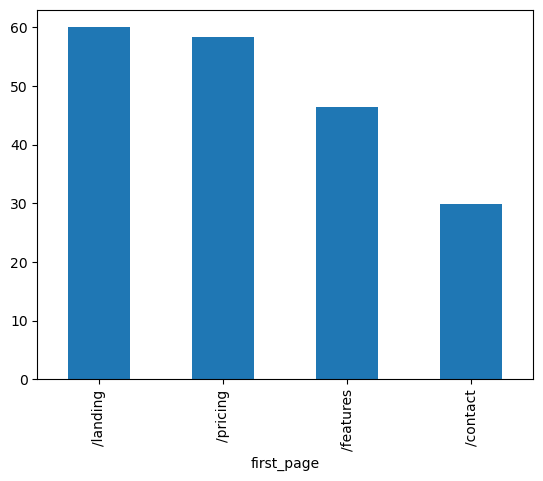

In [107]:
plot_conversion_rate_by_column(merged_df, "first_page")

In [118]:
merged_df[merged_df["user_id"] == 161].duplicated()

28     False
29     False
30     False
31     False
32     False
35     False
36     False
37     False
38     False
39     False
76     False
77     False
78     False
79     False
80     False
109    False
110    False
111    False
112    False
113    False
dtype: bool

numb_pages
4    100.000000
5     50.000000
1     45.833333
2     37.500000
3     28.571429
Name: lead_status, dtype: float64


<Axes: xlabel='numb_pages'>

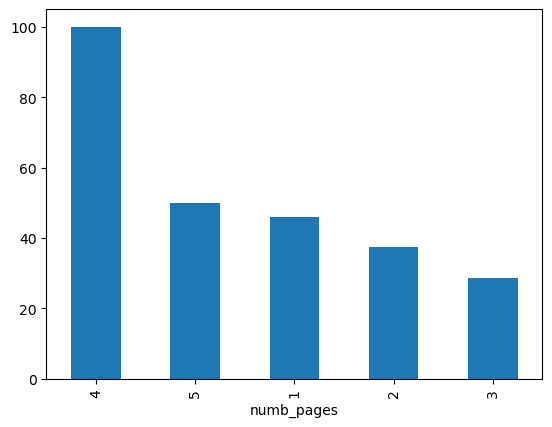

In [111]:
plot_conversion_rate_by_column(merged_df, "numb_pages")

In [96]:
# pandas profiling
crm_profile = ProfileReport(crm_df, 
                            title="CRM Data Profiling Report", 
                            explorative=True)
web_tracking_profile = ProfileReport(web_tracking_df, 
                                     title="Web Tracking Data Profiling Report", 
                                     explorative=True)
crm_profile.to_file("crm_data_profile.html")
web_tracking_profile.to_file("web_tracking_data_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 7/7 [00:00<00:00, 78.61it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 8/8 [00:00<00:00, 109.50it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [38]:
lead_status_dim = crm_df[['lead_status']].drop_duplicates().reset_index(drop=True)
lead_status_dim['lead_status_id'] = lead_status_dim.index + 1

In [39]:
company_dim = crm_df[['company']].drop_duplicates().reset_index(drop=True)
company_dim['company_id'] = company_dim.index + 1

In [40]:
industry_dim = crm_df[['industry']].drop_duplicates().reset_index(drop=True)
industry_dim['industry_id'] = industry_dim.index + 1

In [41]:
country_dim = crm_df[['country']].drop_duplicates().reset_index(drop=True)
country_dim['country_id'] = country_dim.index + 1

In [42]:
# Sign-up time breakdown
crm_df['sign_up_datetime'] = pd.to_datetime(crm_df['sign_up_date'])
sign_up_time_dim = crm_df[['sign_up_datetime']].drop_duplicates().reset_index(drop=True)
sign_up_time_dim['sign_up_time_id'] = sign_up_time_dim.index + 1
sign_up_time_dim['sign_up_year'] = sign_up_time_dim['sign_up_datetime'].dt.year
sign_up_time_dim['sign_up_month'] = sign_up_time_dim['sign_up_datetime'].dt.month
sign_up_time_dim['sign_up_week'] = sign_up_time_dim['sign_up_datetime'].dt.isocalendar().week
sign_up_time_dim['sign_up_weekday'] = sign_up_time_dim['sign_up_datetime'].dt.weekday

In [43]:
# User Dimension Table
user_dim = crm_df.merge(company_dim, on="company")\
.merge(industry_dim, on="industry")\
.merge(country_dim, on="country")\
.merge(sign_up_time_dim, on="sign_up_datetime")\
.merge(lead_status_dim, on="lead_status")\
[["user_id","lead_status_id", "industry_id", "company_id", "country_id", "sign_up_time_id"]].drop_duplicates(subset='user_id')

In [44]:
# Prepare Session Data Dimensions
datetime_dim = web_tracking_df[['timestamp']].drop_duplicates().reset_index(drop=True)
datetime_dim['datetime_id'] = datetime_dim.index + 1
datetime_dim['year'] = datetime_dim['timestamp'].dt.year
datetime_dim['month'] = datetime_dim['timestamp'].dt.month
datetime_dim['week'] = datetime_dim['timestamp'].dt.isocalendar().week
datetime_dim['weekday'] = datetime_dim['timestamp'].dt.weekday

In [45]:
page_dim = web_tracking_df[['page']].drop_duplicates().reset_index(drop=True)
page_dim['page_id'] = page_dim.index + 1

In [46]:
utm_source_dim = web_tracking_df[['utm_source']].drop_duplicates().reset_index(drop=True)
utm_source_dim['utm_source_id'] = utm_source_dim.index + 1

In [47]:
utm_medium_dim = web_tracking_df[['utm_medium']].drop_duplicates().reset_index(drop=True)
utm_medium_dim['utm_medium_id'] = utm_medium_dim.index + 1

In [48]:
device_type_dim = web_tracking_df[['device_type']].drop_duplicates().reset_index(drop=True)
device_type_dim['device_type_id'] = device_type_dim.index + 1

In [49]:
# Fact Table
fact_table = web_tracking_df.merge(user_dim, on="user_id")\
.merge(datetime_dim, on="timestamp_datetime")\
.merge(page_dim, on="page")\
.merge(utm_source_dim, on="utm_source")\
.merge(utm_medium_dim, on="utm_medium")\
.merge(device_type_dim, on="device_type")\
[['session_id', 'user_id', 'datetime_id', 'page_id', 'utm_source_id', 'utm_medium_id', 'device_type_id', 'time_spent_sec']]

KeyError: 'timestamp_datetime'